In [1]:
#some of these maybe not needed anymore...
import numpy as np
import os
import cv2
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.feature import greycoprops, greycomatrix, graycoprops, graycomatrix
from skimage.measure import shannon_entropy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, BatchNormalization, Reshape, AveragePooling2D, concatenate, Input
import keras
from sklearn.preprocessing import LabelEncoder
import keras.utils as ku
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time
import warnings
from sklearn.neural_network import MLPRegressor
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = "/content/drive/MyDrive/Skripsi Face Recognition CNN/ORL/"

imgs = [] #image matrix
labels = []

for filename in os.listdir(data_path):
    img = cv2.imread(data_path + filename,0)
    imgs.append(img)
    labels.append(os.path.splitext(filename)[0].split('_')[1])

In [3]:
#Image
# Split data into train-validation set and test set (80-20 split)
X_train_val_img, X_test_img, y_train_val_img, y_test_img = train_test_split(imgs, labels, test_size=0.2, stratify=labels, random_state=42)

# Split train-validation set into train set and validation set (75-25 split)
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(X_train_val_img, y_train_val_img, test_size=0.25, stratify=y_train_val_img, random_state=42)

X_train_img = np.array(X_train_img)
X_val_img = np.array(X_val_img)
X_test_img = np.array(X_test_img)
# y_train_img = np.array(y_train_img)
# y_val_img = np.array(y_val_img)
# y_test_img = np.array(y_test_img)

# Print the shapes of the resulting sets
print("Training set:", X_train_img.shape)
print("Validation set:", X_val_img.shape)
print("Test set:", X_test_img.shape)

Training set: (240, 80, 70)
Validation set: (80, 80, 70)
Test set: (80, 80, 70)


In [4]:
# Encode labels
le = LabelEncoder()

train_labels_encoded = le.fit_transform(y_train_img)
y_train_img = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_val_img)
y_val_img = to_categorical(train_labels_encoded)

train_labels_encoded = le.fit_transform(y_test_img)
y_test_img = to_categorical(train_labels_encoded)

In [5]:
#For Image
def build_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape = (80, 70, 1), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = 535, activation = 'relu'))
    model.add(Dense(units = 535, activation = 'relu'))
    model.add(Dropout(0.5))
    print(model.summary())
    return model

In [8]:
#concatenate

cnn = build_cnn()

combinedInput = concatenate([cnn.output])

x = Dense(40, activation="softmax")(combinedInput)

model = Model(inputs=cnn.input, outputs=x)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 78, 68, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 34, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 39, 34, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 37, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 16, 64)       0         
 2D)                                                             
                                                      

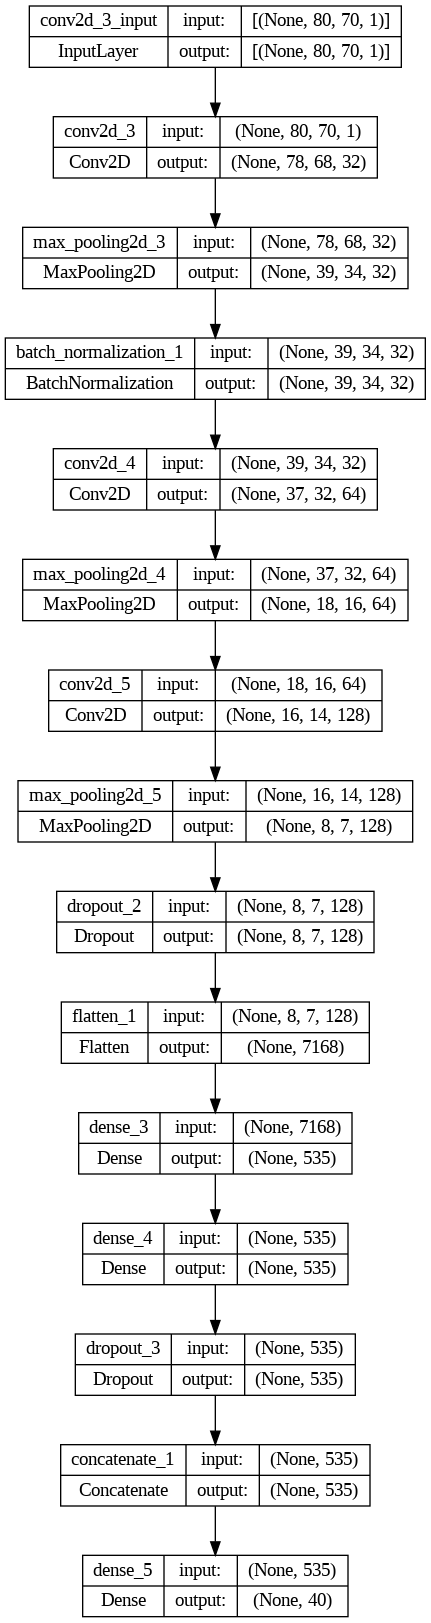

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [10]:
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('dct-weights.{epoch:02d}.h5', save_weights_only=True)


cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    ),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
    checkpoint
]

In [12]:
start = time.time()
history = model.fit(X_train_img, y_train_img, epochs=100, batch_size=16, validation_data=(X_val_img, y_val_img), callbacks = cb)
finish = time.time()


Epoch 1/100
15/15 [==============================] - 4s 220ms/step - loss: 3.9451 - accuracy: 0.0375 - val_loss: 4.1366 - val_accuracy: 0.0250 - lr: 1.0000e-04
Epoch 2/100
15/15 [==============================] - 3s 197ms/step - loss: 3.6157 - accuracy: 0.0583 - val_loss: 3.6417 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 3/100
15/15 [==============================] - 4s 277ms/step - loss: 3.3836 - accuracy: 0.1125 - val_loss: 3.5636 - val_accuracy: 0.0750 - lr: 1.0000e-04
Epoch 4/100
15/15 [==============================] - 4s 244ms/step - loss: 3.1898 - accuracy: 0.1583 - val_loss: 3.4266 - val_accuracy: 0.0750 - lr: 1.0000e-04
Epoch 5/100
15/15 [==============================] - 3s 190ms/step - loss: 2.8960 - accuracy: 0.2792 - val_loss: 3.3781 - val_accuracy: 0.0500 - lr: 1.0000e-04
Epoch 6/100
15/15 [==============================] - 3s 196ms/step - loss: 2.6082 - accuracy: 0.3208 - val_loss: 3.0735 - val_accuracy: 0.2125 - lr: 1.0000e-04
Epoch 7/100
15/15 [=====================

In [13]:
print('Training time : ', str(finish-start), "second(s)")

Training time :  156.4713635444641 second(s)


In [14]:
start_test = time.time()
test_loss, test_acc = model.evaluate(X_test_img, y_test_img)
finish_test = time.time()
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Testing time : ', str(finish_test-start_test), "second(s)")

3/3 [==============================] - 0s 59ms/step - loss: 0.1693 - accuracy: 0.9625
Test loss: 0.16931065917015076
Test accuracy: 0.9624999761581421
Testing time :  46.92038130760193 second(s)


In [15]:
# Extract features from the trained CNN model
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)
train_features = feature_extractor.predict(X_train_img)
test_features = feature_extractor.predict(X_test_img)


3/3 [==============================] - 0s 111ms/step


In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(train_features, np.argmax(y_train_img, axis=1))
train_features_lda = lda.transform(train_features)
test_features_lda = lda.transform(test_features)

In [18]:
train_features_lda.shape

(240, 39)

In [21]:
classifier = Sequential()
classifier.add(Dense(40, activation='softmax', input_shape=(39,)))  # Number of classes = 10
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(train_features_lda, y_train_img, batch_size=128, epochs=100, verbose=1)


Epoch 1/100
2/2 [==============================] - 1s 10ms/step - loss: 10.1524 - accuracy: 0.0042
Epoch 2/100
2/2 [==============================] - 0s 7ms/step - loss: 9.8552 - accuracy: 0.0083
Epoch 3/100
2/2 [==============================] - 0s 11ms/step - loss: 9.5658 - accuracy: 0.0125
Epoch 4/100
2/2 [==============================] - 0s 8ms/step - loss: 9.2847 - accuracy: 0.0125
Epoch 5/100
2/2 [==============================] - 0s 9ms/step - loss: 9.0050 - accuracy: 0.0167
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 8.7284 - accuracy: 0.0208
Epoch 7/100
2/2 [==============================] - 0s 8ms/step - loss: 8.4572 - accuracy: 0.0292
Epoch 8/100
2/2 [==============================] - 0s 8ms/step - loss: 8.1872 - accuracy: 0.0375
Epoch 9/100
2/2 [==============================] - 0s 8ms/step - loss: 7.9216 - accuracy: 0.0500
Epoch 10/100
2/2 [==============================] - 0s 8ms/step - loss: 7.6599 - accuracy: 0.0625
Epoch 11/100
2/2 [========

In [22]:
# Evaluate the classifier on test data
predictions = np.argmax(classifier.predict(test_features_lda), axis=1)
y_test_labels = np.argmax(y_test_img, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))

3/3 [==============================] - 0s 3ms/step
Accuracy: 85.00%
